<a href="https://colab.research.google.com/github/trdvangraft/TUD-DistributedSystems/blob/master/dayaheadforecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob
import math

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing data
In this section we will preprocess the day-ahead electricity price data and the available weather data. Furthermore we will give some summary statistics about the data such that you get some insight in how the data is distributed

In [ ]:
electricty_paths = glob.glob('/content/drive/My Drive/deeplearning/forecastingdata/energydata/*.csv')

# concat all the years of electricy pricing together
energy_data = pd.concat((pd.read_csv(
    file_name,
    header = 0,
    names = ['timestamp', 'price'],
    ) for file_name in electricty_paths))

# replace the "-" for data that we dont have yet
energy_data['price'] = energy_data['price'].replace('-', np.NaN).astype('float64')

new = energy_data["timestamp"].str.split(" ", expand = True)
energy_data['timestamp'] = pd.to_datetime(new[0] + " " + new[1])

energy_data = energy_data.set_index('timestamp')

energy_data.head()

,price
timestamp,
2020-01-01 00:00:00,38.60
2020-01-01 01:00:00,36.55
2020-01-01 02:00:00,32.32
2020-01-01 03:00:00,30.85
2020-01-01 04:00:00,30.14


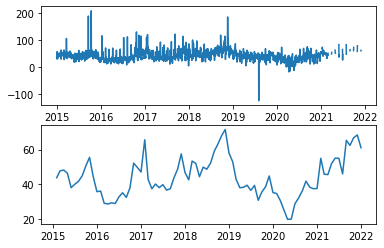

In [ ]:
mean_day_price = energy_data.resample('D').price.mean()
mean_month_price = energy_data.resample('M').price.mean()

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(mean_day_price)
ax2.plot(mean_month_price)

plt.show()

,tempC,windspeedKmph,winddirDegree,precipMM,humidity,pressure,HeatIndexC,FeelsLikeC
count,54024.000000,54024.000000,54024.000000,54024.000000,54024.000000,54024.000000,54024.000000,54024.000000
mean,11.325763,15.453965,192.013883,0.111767,77.077706,1016.253665,11.516937,9.639123
std,6.843186,7.972601,83.862283,0.342913,13.659146,9.737637,7.112374,8.421772
min,-10.000000,0.000000,0.000000,0.000000,20.000000,972.000000,-10.000000,-17.000000
25%,6.000000,10.000000,137.000000,0.000000,68.000000,1011.000000,6.000000,3.000000
50%,11.000000,14.000000,211.000000,0.000000,80.000000,1017.000000,11.000000,9.000000
75%,16.000000,20.000000,246.000000,0.100000,88.000000,1023.000000,16.000000,16.000000
max,39.000000,60.000000,360.000000,5.500000,100.000000,1047.000000,41.000000,41.000000


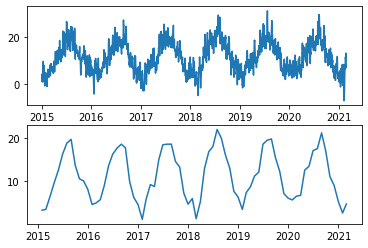

In [ ]:
weather_data = pd.read_json('/content/drive/My Drive/deeplearning/forecastingdata/weatherdata/parsed_weather.json')
hours = [f"{hour}:00:00" for hour in range(0, 24)]
mil_time = [mil_hour for mil_hour in range(0, 2300, 100)]
rep_opp = {mil_hour: hour for mil_hour, hour in zip(mil_time, hours)}

weather_data['timestamp'] = pd.to_datetime(weather_data['date'].astype('str') + ' ' + weather_data['time'].replace(rep_opp).astype('str'))
weather_data = weather_data.drop(['date', 'time'], axis = 1).set_index('timestamp')

mean_day_temp = weather_data.resample('D').tempC.mean()
mean_month_temp = weather_data.resample('M').tempC.mean()

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(mean_day_temp)
ax2.plot(mean_month_temp)

weather_data.describe(include=[np.number])

In [ ]:
renewable_path = glob.glob('/content/drive/My Drive/deeplearning/forecastingdata/renewable/*.csv')

names = [f"{type}_{horizon}" for type in ['solar', 'wind_offshore', 'wind_onshore'] for horizon in ['day_ahead', 'intraday', 'current']]
types = {col_name: np.int32 for col_name in names}

# concat all the years of electricy pricing together
renewable_data = pd.concat((pd.read_csv(
    file_name,
    header = 0,
    names = ["timestamp"] + names,
    ) for file_name in renewable_path)).dropna()



# replace the "-" for data that we dont have yet
renewable_data = renewable_data.replace(['-', 'n/e'], 0)
renewable_data = renewable_data.astype(types)

new = renewable_data["timestamp"].str.split(" ", expand = True)

renewable_data['timestamp'] = pd.to_datetime(new[0] + " " + new[1])
renewable_data = renewable_data.set_index('timestamp')

renewable_data.describe(include=[np.number])

,solar_day_ahead,solar_intraday,solar_current,wind_offshore_day_ahead,wind_offshore_intraday,wind_offshore_current,wind_onshore_day_ahead,wind_onshore_intraday,wind_onshore_current
count,54024.000000,54024.000000,54024.000000,54024.000000,54024.000000,54024.000000,54024.000000,54024.000000,54024.000000
mean,377.548460,219.532560,219.566359,461.536040,328.772138,326.183863,370.138975,225.013161,221.466274
std,602.591438,530.455714,530.716690,450.173422,508.919915,507.466039,342.334838,347.694278,345.522657
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,106.000000,0.000000,0.000000,111.000000,0.000000,0.000000
50%,9.000000,0.000000,0.000000,323.000000,12.000000,11.000000,254.000000,46.000000,43.000000
75%,564.000000,27.000000,27.000000,661.000000,516.000000,510.000000,529.000000,319.000000,310.000000
max,3221.000000,3369.000000,3369.000000,2125.000000,2133.000000,2133.000000,1836.000000,1833.000000,1814.000000


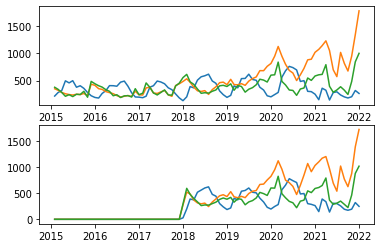

In [ ]:
monthly_forecasts = renewable_data.resample('M').agg({ 'solar_day_ahead': np.mean, 'wind_offshore_day_ahead': np.mean, 'wind_onshore_day_ahead': np.mean })
intraday_forecasts = renewable_data.resample('M').agg({ 'solar_intraday': np.mean, 'wind_offshore_intraday': np.mean, 'wind_onshore_intraday': np.mean })

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(monthly_forecasts)
ax2.plot(intraday_forecasts)

# weather_data.describe(include=[np.number])

In [ ]:
# merge all the data in one dataframe
df = energy_data.merge(weather_data, left_index=True, right_index=True).merge(renewable_data, left_index = True, right_index = True)

# implementing the `incremental indexing` as mentioned in the paper
df['time-incremental_indexing'] = (df.index.hour + 1) / 10.0

# remove na rows from the dataset
df = df.dropna()

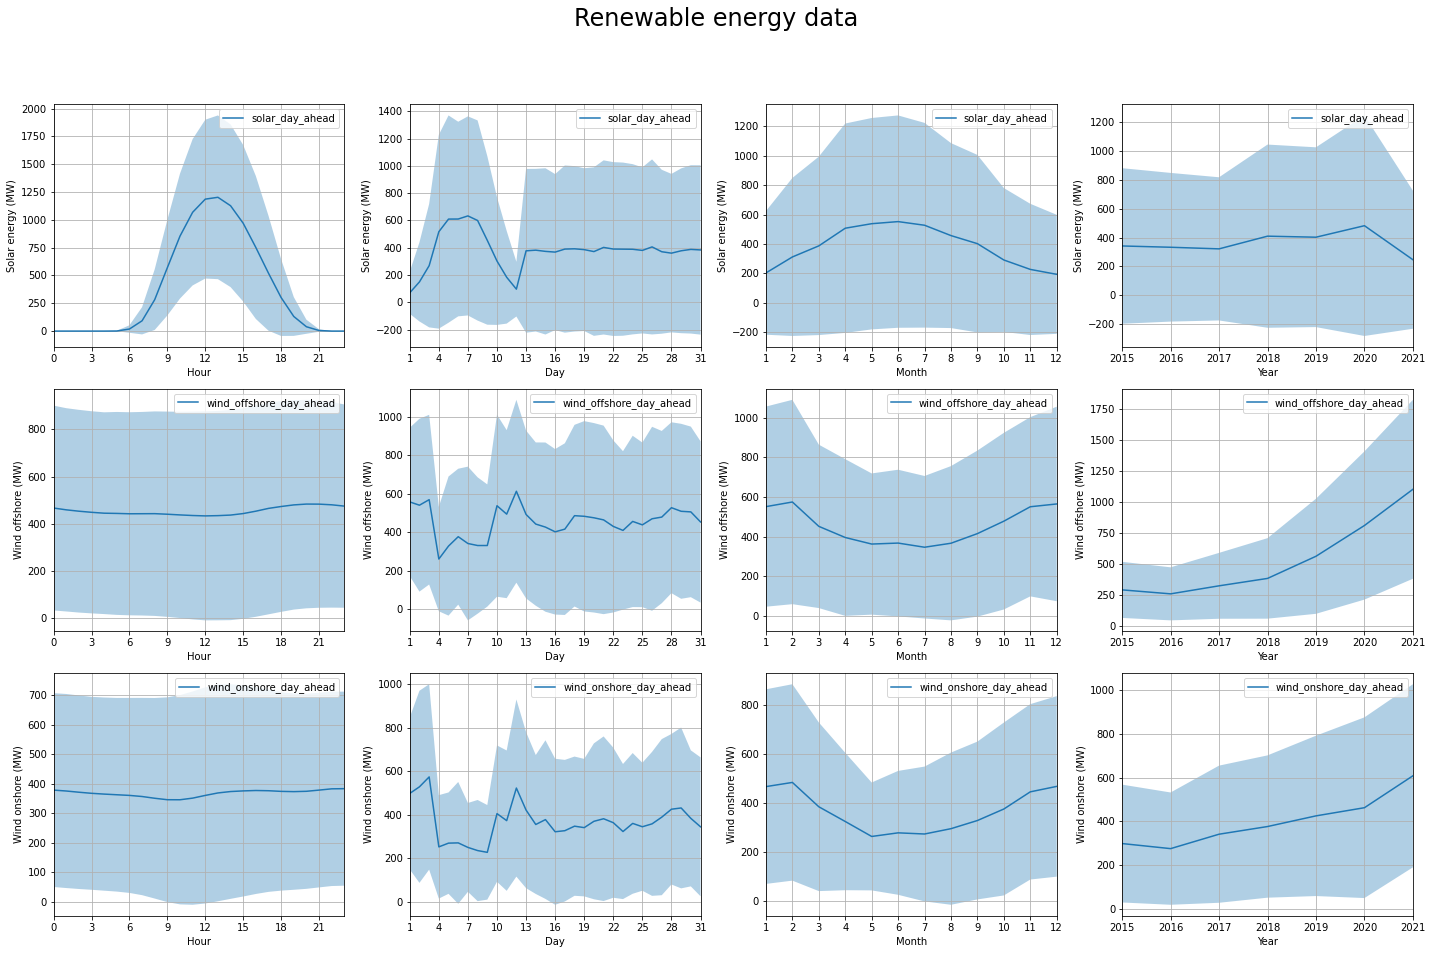

In [ ]:
# render some vizulation for a single day 
def viz_day(data):
  important_labels = [['price'], ['tempC'], ['windspeedKmph'], ['solar_day_ahead', 'wind_offshore_day_ahead', 'wind_onshore_day_ahead']]
  axis_label = ['Price (Euro)', 'Temperature (c)', 'Windspeed (kmph)', 'Renewable energy (MW)']
  
  fig, axes = plt.subplots(len(important_labels), 1, sharex=True, figsize = (20, 10))

  for label, ax, axis_label in zip(important_labels, axes, axis_label):
    mean_data, std_data = data[[(key, 'mean') for key in label]], data[[(key, 'std') for key in label]]
    mean_data.columns, std_data.columns = label, label

    ax.plot(mean_data.index, mean_data)
    ax.set_ylabel(axis_label)

    for _label in label:
      ax.fill_between(mean_data.index, 
                      mean_data[_label].add(std_data[_label]).values.flatten(), 
                      mean_data[_label].sub(std_data[_label]).values.flatten(),
                      alpha = 0.35)
      
    ax.legend(label, loc="upper right")
    ax.grid()
    ax.set_xlim([0, mean_data.shape[0]])

def viz_category(data, important_labels, axis_labels, title, save=False): 
  horizons = [data.index.hour, data.index.day, data.index.month, data.index.year]
  horizon_labels = ['Hour', 'Day', 'Month', 'Year'] 
  fig, plt_axes = plt.subplots(len(important_labels), len(horizons), figsize = (20, 5 * len(important_labels)))

  for idx, (horizon, horizon_label) in enumerate(zip(horizons, horizon_labels)):
    agg = data.groupby(horizon).agg({ key[0]: [np.mean, np.std] for key in important_labels})

    axes = [plt_axes[idx]] if plt_axes.ndim == 1 else plt_axes[:, idx]
    
    for label, ax, axis_label in zip(important_labels, axes, axis_labels):
      mean_data, std_data = agg[[(key, 'mean') for key in label]], agg[[(key, 'std') for key in label]]
      mean_data.columns, std_data.columns = label, label

      ax.plot(range(len(mean_data.index)), mean_data)
      ax.set_ylabel(axis_label)
      ax.set_xlabel(horizon_label)
      ax.set_xticks(range(0, len(mean_data.index), 3 if len(mean_data.index) > 12 else 1))
      ax.set_xticklabels([mean_data.index[i] for i in range(0, len(mean_data.index), 3 if len(mean_data.index) > 12 else 1)])

      for _label in label:
        ax.fill_between(range(len(mean_data.index)), 
                        mean_data[_label].add(std_data[_label]).values.flatten(), 
                        mean_data[_label].sub(std_data[_label]).values.flatten(),
                        alpha = 0.35)
        
      ax.legend(label, loc="upper right")
      ax.grid()
      ax.set_xlim([0, len(mean_data.index) - 1])
  
  fig.suptitle(title, fontsize = 24)
  plt.tight_layout(rect=[0, 0.1, 1, 0.90])
  if save:
    fig.savefig(f"drive/My Drive/deeplearning/preprocessing/{title.lower().replace(' ', '_')}")

aggregated = df.groupby([df.index.year]).agg({
    'price': [np.mean, np.std],
    'tempC': [np.mean, np.std],
    'windspeedKmph': [np.mean, np.std],
    'solar_day_ahead': [np.mean, np.std], 
    'wind_offshore_day_ahead': [np.mean, np.std], 
    'wind_onshore_day_ahead': [np.mean, np.std] })

# Some example how you can vizualizes various values of our dataset
# viz_day(aggregated)
# viz_category(df, [['tempC'], ['windspeedKmph']], ['Temepature (c)', 'Windspeed (kmph)'], 'Weather data')
# viz_category(df, [['price']], ['Price (Euro)'], 'Price data')
viz_category(df, [['solar_day_ahead'], ['wind_offshore_day_ahead'], ['wind_onshore_day_ahead']], ['Solar energy (MW)', 'Wind offshore (MW)', 'Wind onshore (MW)'], 'Renewable energy data')

#Encodings

In [ ]:
# implementing `grey encoding` for the time data
CONST_GREY_CODE = np.array([
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1],
  [0, 0, 0, 1, 1],
  [0, 0, 0, 1, 0],
  [0, 0, 1, 1, 0],
  [0, 0, 1, 1, 1],
  [0, 0, 1, 0, 1],
  [0, 0, 1, 0, 0],
  [0, 1, 1, 0, 0],
  [0, 1, 1, 0, 1],
  [0, 1, 1, 1, 1],
  [0, 1, 1, 1, 0],
  [0, 1, 0, 1, 0],
  [0, 1, 0, 1, 1],
  [0, 1, 0, 0, 1],
  [0, 1, 0, 0, 0],
  [1, 1, 0, 0, 0],
  [1, 1, 0, 0, 1],
  [1, 1, 0, 1, 1],
  [1, 1, 0, 1, 0],
  [1, 1, 1, 1, 0],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 0, 1],
  [1, 1, 1, 0, 0],
  [1, 0, 1, 0, 0],
  [1, 0, 1, 0, 1],
  [1, 0, 1, 1, 1],
  [1, 0, 1, 1, 0],
  [1, 0, 0, 1, 0],
  [1, 0, 0, 1, 1],
  [1, 0, 0, 0, 1],
  [1, 0, 0, 0, 0]
], dtype=np.uint8)

def greyEncoding(df):
  '''    
  INPUTS
  ------
    hour : A numpy array of length N, consisting of positive values only.
           According to the paper, the grey encodings should start from
           00001 and end at 10100, indicating that the hours in the input
           array must range from 1 to 24. This function assumes this fact
           has been taken into account while preparing the input array.

  OUTPUTS
  -------
    GreyEncodings : a N x 5 numpy unit8 array, with 0 or 1 as its entries.
  '''
  hour = df.index.hour.to_numpy() + 1
  N = hour.shape[0]
  GreyEncodings = np.empty(shape=(N, 5), dtype=np.uint8)
  GreyEncodings[:] = CONST_GREY_CODE[hour.astype(np.uint8)]

  return pd.DataFrame(GreyEncodings, index = df.index)

In [ ]:
# implementing `mutually exclusive binary encoding` as mentioned in the paper
def binaryEncoding(df):
  '''    
  INPUTS
  ------
    hour : A numpy array of length N, consisting of positive values only.
           According to the paper, the grey encodings should start from
           00001 and end at 10100, indicating that the hours in the input
           array must range from 1 to 24. Keeping this in mind, this function
           assumes this fact has been accounted for when preparing the input
           array and returns an array reflecting the same.

  OUTPUTS
  -------
    BinaryEncodings : a N x 24 numpy unit8 array, with 0 or 1 as its entries.
  '''
  hour = df.index.hour.to_numpy() + 1
  N = hour.shape[0]
  BinaryEncodings = np.zeros(shape=(N, 24), dtype=np.uint8)
  idx = np.array([24*i + j for i, j in zip(range(N), hour.astype(np.uint8) - 1)])
  np.put(BinaryEncodings, idx, 1)
  del(idx)

  return pd.DataFrame(BinaryEncodings, index = df.index)

In [ ]:
# Grey encoding of the time for energy_data
energy_data_GE = greyEncoding(energy_data)
# Mutually exclusive binary encoding of the time for energy_data
# energy_data_MEBE = binaryEncoding(energy_data.index)

# Grey encoding of the time for weather_data
weather_data_GE = greyEncoding(weather_data)
# Mutually exclusive binary encoding of the time for weather_data
# weather_data_MEBE = binaryEncoding(weather_data.index)


## Embedding steps
We want each sample to consist of 24 hours of the current day (t) and the 24 hours same day last week (t - 1) each sample therefore consist of 48 hours of information. We are intrested in the renewable energy, the price, the scheduled generation and weather information (tempC, windspeedKmph)

In [ ]:
# Scale the dataset such that the mean is zero and the std is 1
# This is necessary to get stable results from the BLSTM
normalized_df = (df - df.mean())/df.std()
normalized_df

                     FeelsLikeC  HeatIndexC  ...  winddirDegree  windspeedKmph
timestamp                                    ...                              
2015-01-02 00:00:00   -1.885319   -1.501380  ...       0.188118       2.457324
2015-01-02 01:00:00   -1.885319   -1.501380  ...       0.212046       2.457324
2015-01-02 02:00:00   -1.765412   -1.501380  ...       0.224010       2.457324
2015-01-02 03:00:00   -1.765412   -1.359528  ...       0.247938       2.457324
2015-01-02 04:00:00   -1.645505   -1.359528  ...       0.235974       2.331791

[5 rows x 21 columns]


In [ ]:
feature_labels = ['price', 'tempC', 'windspeedKmph', 'solar_day_ahead', 'wind_offshore_day_ahead', 'wind_onshore_day_ahead']

binary_labels = binaryEncoding(df)
grey_labels = greyEncoding(df)

N = len(set(normalized_df.index.date)) # batches
D = len(feature_labels) + 24 # number of features
T = 24 # number of timestamps
HORIZON = 1 # number of days ahead we want to forecast
FULL_DAYS = range(math.floor(normalized_df.shape[0]/N) * N)

embedded_data = pd.concat([normalized_df.loc[:, feature_labels], binary_labels], axis = 1).iloc[FULL_DAYS, :].values.reshape((N, T, D))[:-HORIZON]
target_data = normalized_df.iloc[FULL_DAYS, :].loc[:, 'price'].values.reshape((N, T, 1))[HORIZON:]
date_index = df.iloc[FULL_DAYS, :].index.to_numpy().reshape((N, T))[HORIZON:][-31:, 0]



# samples = np.asarray([sample for sample in continious_window(normalized_df, feature_labels, T)])
# samples.shape

# embedded_data = samples[:-HORIZON]
# target_data = samples[HORIZON:]

# print(embedded_data.shape)
# print(embedded_data[0, :, :])
# print("-------------------")
# print(target_data[0, :, :])
# print(date_index)

In [ ]:
def generate_dataset(df, feature_labels, encoding = None):
  N = len(set(normalized_df.index.date)) # batches
  D = len(feature_labels) # number of features
  T = 24 # number of timestamps
  HORIZON = 1 # number of days ahead we want to forecast
  FULL_DAYS = range(math.floor(normalized_df.shape[0]/N) * N)

  if encoding is not None:
    time_encoding = encoding(df)
    D = D + time_encoding.shape[1]
    embedded_data = pd.concat([normalized_df.loc[:, feature_labels], time_encoding], axis = 1).iloc[FULL_DAYS, :].values.reshape((N, T, D))[:-HORIZON]
  else:
    print(feature_labels)
    embedded_data = normalized_df.loc[:, feature_labels].iloc[FULL_DAYS, :].values.reshape((N, T, D))[:-HORIZON]

  target_data = normalized_df.iloc[FULL_DAYS, :].loc[:, 'price'].values.reshape((N, T, 1))[HORIZON:]
  date_index = df.iloc[FULL_DAYS, :].index.to_numpy().reshape((N, T))[HORIZON:][-31:, 0]

  return embedded_data, target_data, date_index

# Models

In [ ]:
# first we will import all the necessary libraries from torch
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, RepeatVector, TimeDistributed, Input
from keras.callbacks import EarlyStopping
from keras.layers.core import Activation
from keras import backend as K

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
print(embedded_data.shape)
print(target_data.shape)

X_train, X_test, Y_train, Y_test = train_test_split(embedded_data, target_data, test_size = 31, shuffle = False)
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

(2214, 24, 30)
(2214, 24, 1)


In [ ]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

def quantile_loss(q, y_true, y_pred):
  e = (y_pred - y_true)
  return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

def unnormalize(origin_df, normalized_df):
  return normalized_df * origin_df.std() + origin_df.mean()


## Standard quantile model with multi output layer

In [ ]:
class QuantileModel():
  def __init__(self, n_timesteps, n_features, n_outputs, quantiles):
    self.n_timesteps = n_timesteps
    self.n_features = n_features
    self.n_outputs = n_outputs
    self.quantiles = quantiles

    self.lstm_neurons = 16
    self.dense_layer = 100

  def build_base_layer(self, inputs):
    # x = Bidirectional(LSTM(self.lstm_neurons))(inputs)
    # x = RepeatVector(self.n_outputs)(x)
    # x = Bidirectional(LSTM(self.lstm_neurons, return_sequences=True))(x)
    # x = TimeDistributed(Dense(self.dense_layer, activation='sigmoid'))(x)

    x = Bidirectional(LSTM(self.lstm_neurons, bias_initializer='random_normal'))(inputs)
    # x = RepeatVector(self.n_outputs)(x)
    # x = Bidirectional(LSTM(self.lstm_neurons, return_sequences=True, bias_initializer='random_normal'))(x)
    # x = TimeDistributed(Dense(self.dense_layer, activation='linear'))(x)
    # x = Dense(self.conversion_layer)(x)

    return x

  def build_quantile_layer(self, inputs, base_layer, name):
    # x = TimeDistributed(Dense(1))(base_layer)
    x = Dense(24)(base_layer)
    x = Activation("linear", name = name)(x)

    return x
  
  def build_model(self):
    input_shape = (self.n_timesteps, self.n_features)
    inputs = Input(shape = input_shape)
    base_layer = self.build_base_layer(inputs)

    model = Model(inputs = inputs,
                  outputs = [self.build_quantile_layer(inputs, base_layer, f"quantile_{q}") for q in self.quantiles],
                  name = "quantile_net")
    
    return model


quantiles = [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]
# quantiles = [0.01, 0.5, 0.99]
# quantiles = [0.01]
model = QuantileModel(n_timesteps, n_features, n_outputs, quantiles).build_model()


In [ ]:
print(quantiles)
loss_dict = {f"quantile_{q}": (lambda y_pred, y_true: quantile_loss(q, y_pred, y_true)) for q in quantiles}

model.compile(
    optimizer="adam", 
    # loss=lambda y_true, y_pred: quantile_loss(quantile, y_true, y_pred) , 
    # loss = root_mean_squared_error,
    loss = loss_dict,
    # metrics = ['mse']
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1, restore_best_weights=True)

model.build((n_timesteps, n_features))
model.summary()

history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size = 16,
    validation_split=0.3,
    callbacks = [es]
)

## ParrallelQuantileModel

In [ ]:
class ParallelQuantileModel():
    def __init__(self, n_timesteps, n_features, n_outputs, quantile):
      self.n_timesteps = n_timesteps
      self.n_features = n_features
      self.n_outputs = n_outputs
      self.quantile = quantile

      self.lstm_neurons = 16
      self.dense_layer = 30
      self.conversion_layer = 16

    def build_layers(self, inputs, name):
      x = Bidirectional(LSTM(self.lstm_neurons, bias_initializer='random_normal'))(inputs)
      # x = RepeatVector(self.n_outputs)(x)
      # x = Bidirectional(LSTM(self.lstm_neurons, return_sequences=True, bias_initializer='random_normal'))(x)
      # x = TimeDistributed(Dense(self.dense_layer, activation='linear'))(x)
      # x = Dense(self.conversion_layer)(x)
      x = Dense(24)(x)
      x = Activation("linear", name = name)(x)

      return x
    
    def build_and_compile_model(self):
      input_shape = (self.n_timesteps, self.n_features)
      inputs = Input(shape = input_shape)
      base_layer = self.build_layers(inputs, f"quantile_{self.quantile}")

      model = Model(inputs = inputs,
                    outputs = base_layer,
                    name = f"quantile_net_{self.quantile}")
      
      model.compile(
          optimizer="adam",
          loss = lambda y_true, y_pred: quantile_loss(self.quantile, y_true, y_pred)
      )

      model.build((self.n_timesteps, self.n_features))
      
      return model

In [ ]:
experiment_name = "testing new setup"
quantiles = [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]

features = ['price', 'tempC', 'windspeedKmph', 'solar_day_ahead', 'wind_offshore_day_ahead', 'wind_onshore_day_ahead']
encoding = binaryEncoding

embedded_data, target_data, date_index = generate_dataset(df, features, encoding = encoding)
X_train, X_test, Y_train, Y_test = get_split(embedded_data, target_data)

callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=4, verbose=1, restore_best_weights=True)]
models = train_experiment(experiment_name, ParallelQuantileModel, X_train, Y_train, callbacks)

expected, predicted = process_model_results(experiment_name, models, X_test, Y_test)
total_quantile_loss = calculate_total_quantile_loss(expected, predicted)

print(total_quantile_loss)

## True Parallel Model
This the final that we have created, this model is a true parallel model as each model has its individual loss function calculated. This has the advantage that we can get a true quantile loss prediction over all our quantiles and allows us to speedup the calculations as each model can be trained in parallel.

In [ ]:
class TrueParallelQuantileModel():
    def __init__(self, n_timesteps, n_features, n_outputs, quantile):
      self.n_timesteps = n_timesteps
      self.n_features = n_features
      self.n_outputs = n_outputs
      self.quantile = quantile

      self.lstm_neurons = 30
      self.dense_layer = 30
      self.conversion_layer = 16

    def build_model(self):
      model = Sequential(name = f"quantile_{self.quantile}")
      model.add(Input(shape = (n_timesteps, n_features)))
      model.add(Bidirectional(LSTM(self.lstm_neurons, bias_initializer='random_normal')))
      model.add(Dense(self.dense_layer, activation='linear'))
      model.add(Dense(24, activation='linear'))

      return model

In [ ]:
quantiles = [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]
inputs = [Input(shape = (n_timesteps, n_features)) for i in range(len(quantiles))]


es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1, restore_best_weights=True)

loss_dict = {f"quantile_{q}": (lambda y_pred, y_true: quantile_loss(q, y_pred, y_true)) for q in quantiles}

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
  models = [TrueParallelQuantileModel(n_timesteps, n_features, n_outputs, q).build_model()(input) for q, input in zip(quantiles, inputs)]
  model = Model(inputs = inputs, outputs = models)

  model.compile(
      optimizer="adam",
      loss = loss_dict
  )

  model.summary()

  history = model.fit(
      [X_train for i in range(len(quantiles))],
      [Y_train for i in range(len(quantiles))],
      epochs=20,
      batch_size = 32,
      validation_split=0.2,
      callbacks = [es]
  )

# Results
In this section we create our evaluation function, it will calculate the quantile loss on the test set and will nicely vizualize the model results.

In [ ]:
def process_model_results(experiment_name, models, X_test, Y_test):
  # redifine our quantiles again as we dont want to abuse the global scope
  quantiles = [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]
  expected = np.squeeze(unnormalize(df.loc[:, 'price'], Y_test)).flatten()
  
  colors = ['#bdbdbd', '#939393', '#696969','#3f3f3f']

  # Depending on the model that was used uncomment on of these lines
  # predicted = model.predict(X_test)
  # predicted = model.predict([X_test for i in range(len(quantiles))])
  predicted = np.array([np.squeeze(unnormalize(df.loc[:, 'price'], model.predict(X_test))).flatten() for model in models])

  fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = False, sharey = True, figsize=(20, 12))
  axes = axes.flatten()

  for idx, ax in enumerate(axes):
    data = predicted[:, idx*7*24:(idx + 1)*7*24]
    date = [pd.to_datetime(x) for x in date_index[idx*7:(idx + 1)*7]]

    ax.plot(expected[idx*7*24:(idx + 1)*7*24], label = "Expected", color = 'red')

    middle = int(len(quantiles)/2)

    for pred_low, q_low, pred_high, q_high, color in zip(data[:middle], quantiles[:middle], data[:-(middle + 1):-1], quantiles[:-(middle + 1):-1], colors):
      ax.fill_between(range(data.shape[1]), 
                      pred_low, 
                      pred_high, 
                      label = f"Quantile {int(q_low * 100)}-{int(q_high * 100)}", alpha = 0.8, facecolor = color)

    ax.set_title(f"Window ({date[0].day}, {date[0].month_name()}, {date[0].year}) - ({date[-1].day}, {date[-1].month_name()}, {date[-1].year})")
    ax.set_xticks(range(12, 7 * 24, 24))
    ax.set_xticklabels([x.day_name() for x in date])
    ax.set_xlabel("Hours")
    ax.set_ylabel("Price (eur)")
    ax.set_xlim([0, 7 * 24 - 1])
    ax.grid()

    for i in range(24, 8 * 24, 24):
      ax.axvline(i, color = 'black', linestyle = '--')
    # plt.bar(, 3.5, bottom = -1.5, width = 0.2, color = 'black', linestyle = 'dashed')
    # plt.legend(['Predicted', 'Expected'])
  plt.xlim([0, 7 * 24 - 1])
  plt.legend()

  fig.suptitle("Forecasts energy market for various windows", fontsize = 24)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig.savefig(f"drive/My Drive/deeplearning/model_{experiment_name}/visualization")

  plt.show()

  return expected, predicted

# Experiments
We want to find out the influence of diffenent selected features and how they effect the model results. We will calculate the overall quantile loss on the test set, which than can be compared to the papers result

In [ ]:
def train_experiment(experiment_name, model_class, X_train, Y_train, callbacks = None):
  quantiles = [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]
  models = []

  n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

  strategy = tf.distribute.MirroredStrategy()
  print("Number of devices: {}".format(strategy.num_replicas_in_sync))

  for q in quantiles:
    print(f"TRAINING A NEW MODEL {q}")

    with strategy.scope():
      model = model_class(n_timesteps, n_features, n_outputs, q).build_and_compile_model()
      # model.summary()

    if callbacks is None:
      callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=0, restore_best_weights=True)]

    history = model.fit(
        X_train,
        Y_train,
        epochs=100,
        batch_size = 16,
        validation_split=0.2,
        callbacks = callbacks,
        verbose = 0
    )

    model.save(f"drive/My Drive/deeplearning/model_{experiment_name}/quantile_{q}", save_format = 'h5')
    models.append(model)

  return models

In [ ]:
def calculate_total_quantile_loss(expected, predicted):
  quantiles = [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]
  return np.sum(np.mean([quantile_loss(q, expected.reshape((-1, 24)).T, predicted[idx].reshape((-1, 24)).T) for idx, q in enumerate(quantiles)], axis = 0))

In [ ]:
def get_split(embedded_data, target_data):
  X_train, X_test, Y_train, Y_test = train_test_split(embedded_data, target_data, test_size = 31, shuffle = False)
  return X_train, X_test, Y_train, Y_test

In [ ]:
feature_names = {"price":["price"], 
                 "weather":['price', 'tempC', 'windspeedKmph'], 
                 "ev":['price', 'solar_day_ahead', 'wind_offshore_day_ahead', 'wind_onshore_day_ahead'], 
                 "full": ['price', 'tempC', 'windspeedKmph', 'solar_day_ahead', 'wind_offshore_day_ahead', 'wind_onshore_day_ahead']}
encoding_names = {"no_encoding": None, "binary_encoding": binaryEncoding, "grey_encoding": greyEncoding}
quantiles = [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]

for f_key, e_key in [(f_key, e_key) for f_key in feature_names.keys() for e_key in encoding_names.keys()]:
  experiment_name = f"{f_key}_features_paralization_{e_key}"
  print(experiment_name)

  features = feature_names[f_key]
  encoding = encoding_names[e_key]

  embedded_data, target_data, date_index = generate_dataset(df, features, encoding = encoding)
  X_train, X_test, Y_train, Y_test = get_split(embedded_data, target_data)

  models = train_experiment(experiment_name, ParallelQuantileModel, X_train, Y_train)

  expected, predicted = process_model_results(experiment_name, models, X_test, Y_test)
  total_quantile_loss = calculate_total_quantile_loss(expected, predicted)

  with open(f"drive/My Drive/deeplearning/model_{experiment_name}/experiment_summary.txt", "w") as f:
    f.write(f"EXPERIMENT NAME: {experiment_name}\n")
    f.write(f"FEATURES: {','.join(features)} \n")
    f.write(f"ENCODING: {e_key} \n")
    f.write(f"LOSS: {total_quantile_loss} \n")
    f.close()
  
  tf.keras.backend.clear_session()

# Process Experiments
We read all the stored information from the drive and will than use that information to created the overall loss table.

In [ ]:
experiment_paths = glob.glob('/content/drive/My Drive/deeplearning/**/*.txt')
experiment_results = pd.concat([pd.read_csv(path, sep=":", index_col=0) for path in experiment_paths], axis = 1)
experiment_results.index.name = None

results = pd.DataFrame({ key: experiment_results.loc['LOSS', experiment_results.columns.map(lambda x: key in x)].values for key in encoding_names.keys() }, index = feature_names.keys())

results

,no_encoding,binary_encoding,grey_encoding
price,34.84877634425317,34.483216414297786,34.69365827483516
weather,33.60259530352008,33.042825592948546,33.668087849232464
ev,35.261084937664776,34.46687064147765,35.82440931573991
full,35.34825963281816,34.8533746415569,35.633760633622444
